# Text Generation with Transformers

In this notebook we use the components developed in `modelling.transformer` to train a transformer decoder for our text generation task. We will compare the performance of this model with that established by our RNN baseline.

## Imports

The bulk of the code required to setup, train and generate new text from the model, is contained within `modelling.transformer` (check the source code for the details). We import this module together with others that serve the training data and manage model persistence.

In [1]:
import warnings

from torch import device
from torch.utils.data import DataLoader

from modelling import data as data
from modelling import transformer as tfr
from modelling import utils as utils

warnings.filterwarnings("ignore")

## Model and Training Parameters

Configure hyper-parameters for the model and the training routine.

In [2]:
MODEL_NAME = "decoder_next_word_gen"

SIZE_EMBED = 256

MAX_EPOCHS = 30
BATCH_SIZE = 64
SEQ_LEN = 100
MIN_WORD_FREQ = 1
MAX_LEARNING_RATE = 0.001
WARMUP_EPOCHS = 2
GRADIENT_CLIP = 5

DEVICE = device("cpu")

Note that we have explicitly chosen to train this model on the CPU as the MPS backend (for Apple silicon) doesn't (yet) have support for all the calculations required by multi-head attention. Consequently, it has to fall back on the CPU for some calculations and this constant back-and-forth results in significantly longer training times.

## Setup Training Data

In [3]:
datasets = data.make_sequence_datasets(seq_len=SEQ_LEN, min_freq=MIN_WORD_FREQ)

train_dl = DataLoader(
    datasets.train_data,
    batch_size=BATCH_SIZE,
    drop_last=True,
    collate_fn=data.pad_seq2seq_data,
)

val_dl = DataLoader(
    datasets.val_data,
    batch_size=BATCH_SIZE,
    drop_last=True,
    collate_fn=data.pad_seq2seq_data,
)

## Instantiate Model

In [4]:
model = tfr.NextWordPredictionTransformer(datasets.tokenizer.vocab_size, SIZE_EMBED)
model

NextWordPredictionTransformer(
  (_position_encoder): PositionalEncoding(
    (_dropout): Dropout(p=0.1, inplace=False)
  )
  (_embedding): Embedding(133046, 256)
  (_decoder): TransformerDecoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (linear1): Linear(in_features=256, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=512, out_features=256, bias=True)
    (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (norm3): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
    (dropout3): Dropout(p=0.1, inplace=Fa

Let's count how many parameters this model has.

In [5]:
print(f"{utils.count_params(model):,}")

406,306


If we compare this model with the RNN model, then it is easy to see that this one is significantly more complex with many more layers (and thus parameters). We start with the same embedding layer albeit combined with a positional encoding, that is then fed into a transformer decoder layer comprised of two multi-head attention blocks, two linear (dense) feed-forward layers and three sets of layer normalisation and dropout.

## Train

As well as having a far more complex architecture, transformer based models are also trickier to train successfully. In particular, the vast number of parameters can lead to gradients that can grow very large in the early stages of training, thus preventing convergence.

We handle this using a learning rate schedule that starts close to zero and slowly ramps-up, before falling again as we reach the end of the desired number of epochs. We also clip the gradients - see the source code for the full details.

In [6]:
train_losses, val_losses, best_checkpoint = tfr.train(
    model,
    train_dl,
    val_dl,
    MAX_EPOCHS,
    MAX_LEARNING_RATE,
    WARMUP_EPOCHS,
    GRADIENT_CLIP,
    device=DEVICE,
)
utils.save_model(model, name=MODEL_NAME, loss=best_checkpoint.val_loss)

number of warmup steps: 1334 / 20010


epoch 6 training loss = 4.2479 (LR = 0.00090451): 100%|██████████| 667/667 [1:11:57<00:00,  6.47s/it]



best model:
|-- epoch: 4
|-- validation loss: 5.1355


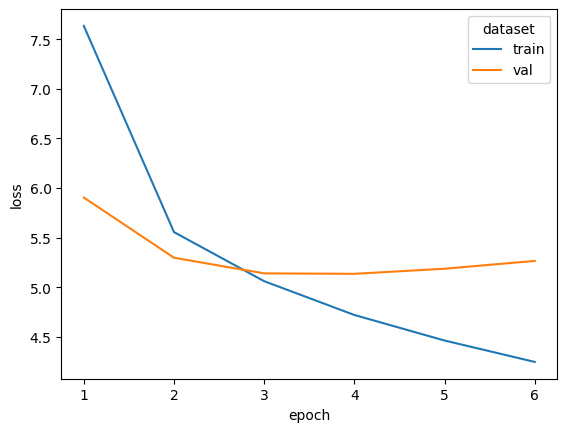

In [7]:
utils.plot_train_losses(train_losses, val_losses)

## Generate Text with Model

Start by loading a model and instantiating a tokenizer that can also map from tokens back to text. The `load_model` function will load the best performing model that has been persisted on the local filesystem.

In [8]:
best_model: tfr.NextWordPredictionTransformer = utils.load_model(MODEL_NAME)

loading .models/decoder_next_word_gen/trained@2023-07-26T17:02:56;loss=5_0291.pt


Then set a prompt.

In [9]:
prompt = "This is a classic horror and"

### Greedy Decoding Strategy

Pass a prompt to the model and use a greedy decoding strategy to generate new text.Now pass a prompt to the model and get it to generate the text that comes after.

In [10]:
text = tfr.generate(
    best_model, prompt, datasets.tokenizer, "greedy", SEQ_LEN, temperature=1.0,
)
print(text)

==> THIS IS A CLASSIC HORROR AND a very good movie. The acting is good and the plot is
very good. The acting is good and the plot is very good. The plot is very good and the
acting is good. The story is very good and the acting is good. The story is very good and
the story is very good. The acting is good and the story is very good. The acting is good
and the story is very good. The story is very good. The story is very good and the story.
The story...


### Top-k Decoding Strategy

Pass a prompt to the model and use a top-k decoding strategy to generate new text (with k=5).

In [11]:
text = tfr.generate(
    best_model, prompt, datasets.tokenizer, "topk", SEQ_LEN, temperature=1.0, k=5
)
print(text)

==> THIS IS A CLASSIC HORROR AND the story of a man who wants a lot of money. I think its
not a movie that has a good message about it. The film has a great deal of humour and
some nice touches. A few good moments and the story is not very good but it doesnt seem
to be much better than it is. I am a big fan of the movie and I have a great time to
watch this film and will definitely be a good horror movie. It is a great film for the
movie that you will...


### Sampling Decoding Strategy

Pass a prompt to the model and use a sampling decoding strategy to generate new text.

In [12]:
text = tfr.generate(
    best_model, prompt, datasets.tokenizer, "sample", SEQ_LEN, temperature=1.0
)
print(text)

==> THIS IS A CLASSIC HORROR AND to its predecessors really believable. The acting
definitely below average quality trashy dates and while I did find the acting
particularly robert walker texas ranger v and twice as if hes suddenly listed on a limb
and even shooting a film. It is the newcomer of all evils children is singularly for an
cowardly nut there was a scene where the boy meowed so supernova and insanity flashback
scenes. I would hope this film will as for the other two bickering bastards. Cause it
could possible such a nightmare with dirty dancing greek dudes in 1985...


### Benchmark

Compare all output with that from an untrained model.And compare this output with that from an untrained model.

In [13]:
untrained_model = tfr.NextWordPredictionTransformer(
    datasets.tokenizer.vocab_size, SIZE_EMBED
)
text = tfr.generate(
    untrained_model, prompt, datasets.tokenizer, "greedy", SEQ_LEN, temperature=1.0
)
print(text)

==> THIS IS A CLASSIC HORROR AND Is1ok chasedkilled chasedkilled coppin coppin coppin
coppin coppin panic dolce dolce capitulates capitulates bisset bisset lollipopscash
kopins inevitabally reynold reynold reynold lollipopscash lollipopscash lollipopscash
lollipopscash seemsconvinced seemsconvinced seemsconvinced bbq bbq bbq bbq riverbed hrs
bbq bbq badgere skews resile resile ticker caveats caveats caveats caveats caveats
everythingsound everythingsound everythingsound everythingsound everythingsound mssmith
bisset bisset entrails kooper filmsscott aerun mssmith mssmith lofgren entrails entrails
entrails entrails entrails entrails vernen toturro bllshit philadelphiapa philadelphiapa
badgere badgere badgere fifties fifties fifties vernen vernen vernen intensely
precondition hashopium peclet vernen vernen vernen vernen badgere badgere misdemeanour
towered trimmer trimmer trimmer trimmer trimmer fifties fifties...
